In [38]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import numpy as np

In [69]:
# Génération du dataset
np.random.seed(42)
n_restaurants = 1000

# Génération des features
data = {
    "price_range": np.random.choice(
        [1, 2, 3, 4], n_restaurants, p=[0.2, 0.35, 0.3, 0.15]
    ),
    "cuisine_type": np.random.choice(
        [
            "Italien",
            "Français",
            "Japonais",
            "Mexicain",
            "Indien",
            "Américain",
            "Chinois",
            "Méditerranéen",
        ],
        n_restaurants,
    ),
    "city_zone": np.random.choice(
        ["Centre", "Banlieue", "Périphérie"], n_restaurants, p=[0.4, 0.35, 0.25]
    ),
    "seating_capacity": np.random.randint(20, 200, n_restaurants),
    "years_open": np.random.randint(1, 30, n_restaurants),
    "has_terrace": np.random.choice([0, 1], n_restaurants, p=[0.6, 0.4]),
    "has_parking": np.random.choice([0, 1], n_restaurants, p=[0.5, 0.5]),
    "delivery_service": np.random.choice([0, 1], n_restaurants, p=[0.4, 0.6]),
    "accepts_reservation": np.random.choice([0, 1], n_restaurants, p=[0.3, 0.7]),
    "vegetarian_options": np.random.choice([0, 1], n_restaurants, p=[0.2, 0.8]),
    "avg_wait_time": np.random.randint(5, 60, n_restaurants),
    "chef_experience": np.random.randint(0, 25, n_restaurants),
}

restaurants = pd.DataFrame(data)

# Génération de la variable cible (rating) basée sur une logique
# Plus de points pour : prix élevé, zone centrale, chef expérimenté, services, ancienneté
score = (
    restaurants["price_range"] * 15
    + restaurants["chef_experience"] * 2
    + restaurants["years_open"] * 1.5
    + (restaurants["city_zone"] == "Centre") * 20
    + restaurants["has_terrace"] * 10
    + restaurants["has_parking"] * 8
    + restaurants["accepts_reservation"] * 12
    + restaurants["vegetarian_options"] * 5
    + (60 - restaurants["avg_wait_time"]) * 0.5
    + np.random.normal(0, 15, n_restaurants)  # Bruit aléatoire
)

# Catégorisation en 4 classes
restaurants["rating_category"] = pd.cut(
    score, bins=4, labels=["Moyen", "Bon", "Très bon", "Excellent"]
)

### 1. Exploration des données

- Générez le dataset avec le code fourni
- Affichez les 10 premières lignes
- Vérifiez s'il y a des valeurs manquantes
- Analysez la distribution des catégories de notation
- Créez un graphique montrant la distribution des ratings par zone de ville
- Créez un graphique montrant la relation entre price_range et rating_category

In [70]:
restaurants.head(10)

,price_range,cuisine_type,city_zone,seating_capacity,years_open,has_terrace,has_parking,delivery_service,accepts_reservation,vegetarian_options,avg_wait_time,chef_experience,rating_category
0,2,Chinois,Banlieue,198,14,0,0,0,1,0,34,15,Bon
1,4,Mexicain,Banlieue,194,10,0,1,1,1,1,25,10,Bon
2,3,Américain,Centre,23,17,0,0,1,0,1,34,3,Bon
3,3,Méditerranéen,Centre,154,10,1,1,1,1,1,32,0,Très bon
4,1,Méditerranéen,Centre,128,26,1,1,0,1,1,35,24,Excellent
5,1,Japonais,Centre,182,7,0,0,1,1,1,56,20,Bon
6,1,Méditerranéen,Banlieue,67,16,1,1,1,1,1,30,21,Très bon
7,4,Chinois,Banlieue,92,1,1,0,1,1,1,47,15,Bon
8,3,Indien,Banlieue,91,17,0,1,0,0,1,26,18,Bon
9,3,Italien,Périphérie,135,21,0,1,0,0,1,25,15,Très bon


In [71]:
restaurants.isna().sum()

price_range            0
cuisine_type           0
city_zone              0
seating_capacity       0
years_open             0
has_terrace            0
has_parking            0
delivery_service       0
accepts_reservation    0
vegetarian_options     0
avg_wait_time          0
chef_experience        0
rating_category        0
dtype: int64

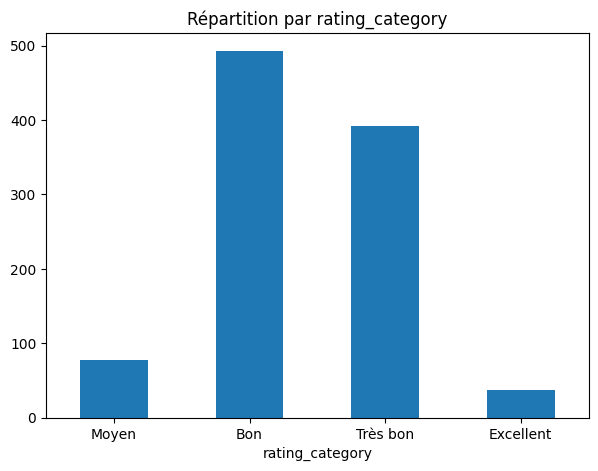

In [72]:
plt.figure(figsize=(7, 5))
plt.title("Répartition par rating_category")

rating_category_count = (
    restaurants["rating_category"].value_counts().sort_index().plot(kind="bar", rot=0)
)

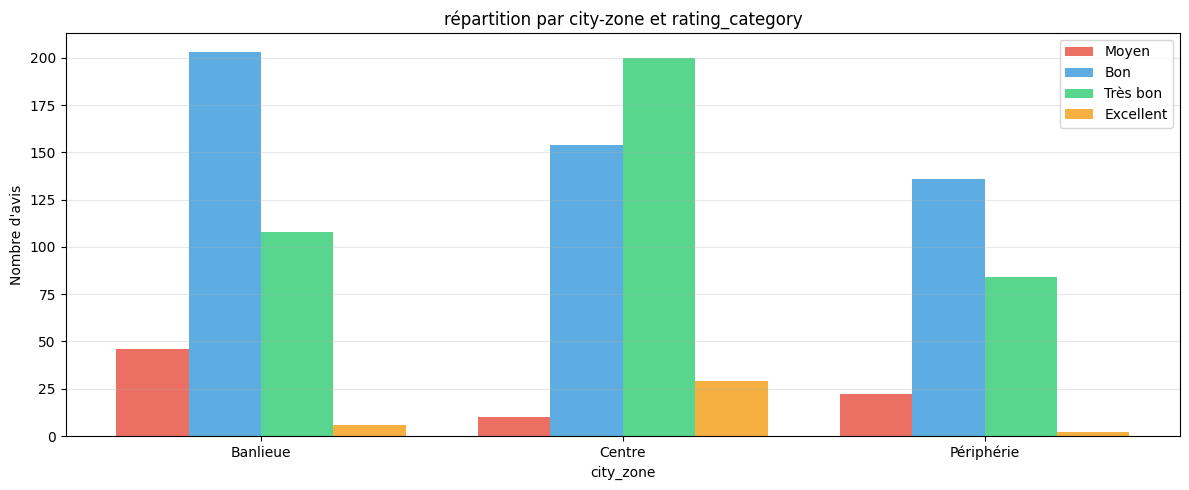

In [73]:
rating_category_city_zone = (
    restaurants.groupby("city_zone")["rating_category"]
    .value_counts()
    .sort_index()
    .unstack()
)

rating_categories = rating_category_city_zone.columns
city_zones = rating_category_city_zone.index

fig, ax = plt.subplots(figsize=(12, 5))

x = np.arange(len(city_zones))
width = 0.2
colors = ["#E74C3C", "#3498DB", "#2ECC71", "#F39C12"]

for i, (rating_category, color) in enumerate(zip(rating_categories, colors)):
    ax.bar(
        x + i * width,
        rating_category_city_zone[rating_category],
        width,
        label=rating_category,
        color=color,
        alpha=0.8,
    )

# Mise en forme
ax.set_xlabel("city_zone")
ax.set_ylabel("Nombre d'avis")
ax.set_title("répartition par city-zone et rating_category")
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(city_zones)
ax.legend()
ax.grid(True, axis="y", alpha=0.3)

plt.tight_layout()

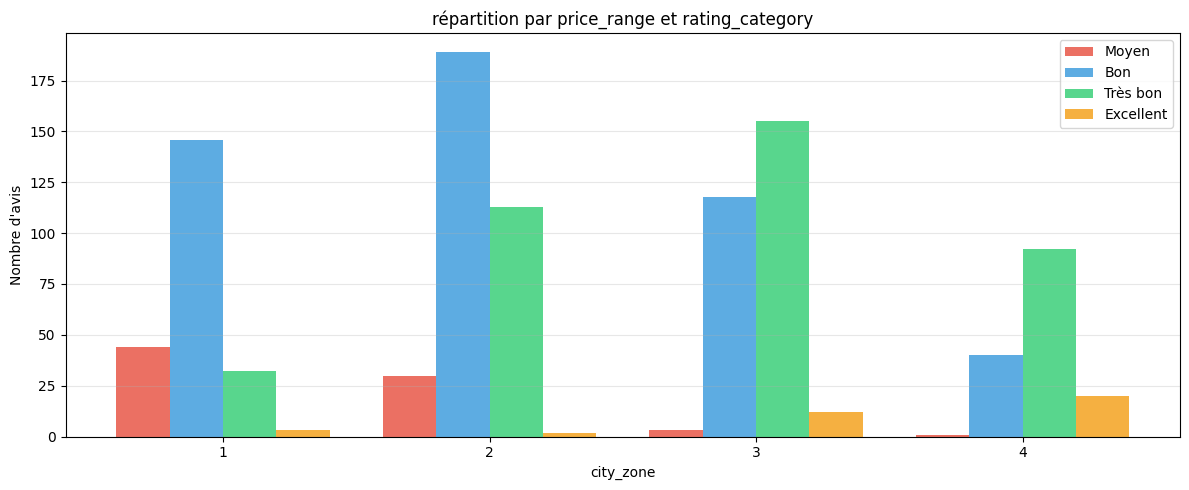

In [74]:
rating_category_price_range = (
    restaurants.groupby("price_range")["rating_category"]
    .value_counts()
    .sort_index()
    .unstack()
)

rating_categories = rating_category_price_range.columns
price_ranges = rating_category_price_range.index

fig, ax = plt.subplots(figsize=(12, 5))

x = np.arange(len(price_ranges))
width = 0.2
colors = ["#E74C3C", "#3498DB", "#2ECC71", "#F39C12"]

for i, (rating_category, color) in enumerate(zip(rating_categories, colors)):
    ax.bar(
        x + i * width,
        rating_category_price_range[rating_category],
        width,
        label=rating_category,
        color=color,
        alpha=0.8,
    )

# Mise en forme
ax.set_xlabel("city_zone")
ax.set_ylabel("Nombre d'avis")
ax.set_title("répartition par price_range et rating_category")
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(price_ranges)
ax.legend()
ax.grid(True, axis="y", alpha=0.3)

plt.tight_layout()

### 2. Préparation des données

- Séparez X (features) et y (target)
- Identifiez les variables numériques et catégorielles
- Encodez les variables catégorielles
- Divisez les données en train/test (80/20)

In [75]:
X = restaurants.drop("rating_category", axis=1)
y = restaurants["rating_category"]

In [76]:
numeric_features = X.select_dtypes(np.number).columns.to_list()
categorical_features = X.select_dtypes("object").columns.to_list()

print("Variables numériques : ", numeric_features)
print("Variables catégorielles : ", categorical_features)

Variables numériques :  ['price_range', 'seating_capacity', 'years_open', 'has_terrace', 'has_parking', 'delivery_service', 'accepts_reservation', 'vegetarian_options', 'avg_wait_time', 'chef_experience']
Variables catégorielles :  ['cuisine_type', 'city_zone']


In [77]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="error")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### 3. Construction des modèles

#### a) K-Nearest Neighbors (KNN)

In [79]:
from sklearn.neighbors import KNeighborsClassifier

kn_pipeline = Pipeline(
    steps=[("processor", preprocessor), ("classifier", KNeighborsClassifier())]
)

kn_pipeline.fit(X_train, y_train)

y_train_pred_kn = kn_pipeline.predict(X_train)
y_test_pred_kn = kn_pipeline.predict(X_test)

print("Accuracy train: ", accuracy_score(y_train, y_train_pred_kn))
print("Accuracy test: ", accuracy_score(y_test, y_test_pred_kn))

print(classification_report(y_test, y_test_pred_kn))

Accuracy train:  0.7186666666666667
Accuracy test:  0.62
              precision    recall  f1-score   support

         Bon       0.63      0.73      0.68       123
   Excellent       0.33      0.11      0.17         9
       Moyen       1.00      0.15      0.26        20
    Très bon       0.60      0.62      0.61        98

    accuracy                           0.62       250
   macro avg       0.64      0.40      0.43       250
weighted avg       0.64      0.62      0.60       250



#### b) Decision Tree (Arbre de décision)

In [80]:
from sklearn.tree import DecisionTreeClassifier

dt_pipeline = Pipeline(
    steps=[
        ("processor", preprocessor),
        ("classifier", DecisionTreeClassifier(random_state=42)),
    ]
)

dt_pipeline.fit(X_train, y_train)

y_train_pred_dt = dt_pipeline.predict(X_train)
y_test_pred_dt = dt_pipeline.predict(X_test)

print("Accuracy train : ", accuracy_score(y_train, y_train_pred_dt))
print("Accuracy test : ", accuracy_score(y_test, y_test_pred_dt))
print(classification_report(y_test, y_test_pred_dt))

Accuracy train :  1.0
Accuracy test :  0.596
              precision    recall  f1-score   support

         Bon       0.66      0.66      0.66       123
   Excellent       0.27      0.33      0.30         9
       Moyen       0.39      0.45      0.42        20
    Très bon       0.60      0.57      0.59        98

    accuracy                           0.60       250
   macro avg       0.48      0.50      0.49       250
weighted avg       0.60      0.60      0.60       250



#### c) Random Forest

In [81]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(
    steps=[
        ("processor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)

rf_pipeline.fit(X_train, y_train)

y_train_pred_rf = rf_pipeline.predict(X_train)
y_test_pred_rf = rf_pipeline.predict(X_test)

print("Accuracy train : ", accuracy_score(y_train, y_train_pred_rf))
print("Accuracy test : ", accuracy_score(y_test, y_test_pred_rf))
print(classification_report(y_test, y_test_pred_rf))

Accuracy train :  1.0
Accuracy test :  0.68
              precision    recall  f1-score   support

         Bon       0.66      0.86      0.75       123
   Excellent       0.00      0.00      0.00         9
       Moyen       0.67      0.10      0.17        20
    Très bon       0.71      0.63      0.67        98

    accuracy                           0.68       250
   macro avg       0.51      0.40      0.40       250
weighted avg       0.66      0.68      0.65       250



c:\Users\Administrateur\Documents\M2i_CDSD_TDTP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrateur\Documents\M2i_CDSD_TDTP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrateur\Documents\M2i_CDSD_TDTP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

### 4. Évaluation et comparaison

Pour chaque modèle evaluez les metriques
Créez un tableau comparatif

In [ ]:
data = {
    "Model": ["KNN", "DecisionTree", "ForestTree"],
    "Accuracy train": [
        accuracy_score(y_train, y_train_pred_kn),
        accuracy_score(y_train, y_train_pred_dt),
        accuracy_score(y_train, y_train_pred_rf),
    ],
    "Accuracy test": [
        accuracy_score(y_test, y_test_pred_kn),
        accuracy_score(y_test, y_test_pred_dt),
        accuracy_score(y_test, y_test_pred_rf),
    ],
}
comparison = pd.DataFrame(data)
comparison.head()

,Model,Accuracy train,Accuracy test
0,KNN,0.718667,0.620
1,DecisionTree,1.000000,0.596
2,ForestTree,1.000000,0.680


### 5. Prédiction sur de nouveaux restaurants

Créez 3 restaurants fictifs et prédisez leur catégorie

In [108]:
def get_restaurant():
    data = {
        "price_range": [np.random.choice([1, 2, 3, 4], p=[0.2, 0.35, 0.3, 0.15])],
        "cuisine_type": [
            np.random.choice(
                [
                    "Italien",
                    "Français",
                    "Japonais",
                    "Mexicain",
                    "Indien",
                    "Américain",
                    "Chinois",
                    "Méditerranéen",
                ]
            )
        ],
        "city_zone": [
            np.random.choice(["Centre", "Banlieue", "Périphérie"], p=[0.4, 0.35, 0.25])
        ],
        "seating_capacity": [np.random.randint(20, 200)],
        "years_open": [np.random.randint(1, 30)],
        "has_terrace": [np.random.choice([0, 1], p=[0.6, 0.4])],
        "has_parking": [np.random.choice([0, 1], p=[0.5, 0.5])],
        "delivery_service": [np.random.choice([0, 1], p=[0.4, 0.6])],
        "accepts_reservation": [np.random.choice([0, 1], p=[0.3, 0.7])],
        "vegetarian_options": [np.random.choice([0, 1], p=[0.2, 0.8])],
        "avg_wait_time": [np.random.randint(5, 60)],
        "chef_experience": [np.random.randint(0, 25)],
    }

    return pd.DataFrame(data)


restaurants = [get_restaurant() for k in range(3)]

print("Prévison")
for i, restaurant in enumerate(restaurants, start=1):
    y_pred = rf_pipeline.predict(restaurant)
    proba = rf_pipeline.predict_proba(restaurant)
    print(f"restaurant {i} : {y_pred[0]} - {proba.max() * 100}%")

Prévison
restaurant 1 : Très bon - 59.0%
restaurant 2 : Très bon - 59.0%
restaurant 3 : Bon - 65.0%
